In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
datapath = "/content/gdrive/My Drive/Datasets/"

Mounted at /content/gdrive


# Library Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader as DL
from torch.utils.data import Dataset
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from time import time

import warnings
warnings.filterwarnings("ignore")

# Helper Functions

In [3]:
def breaker():
  print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
  breaker()
  print(x[:no_of_ele])
  breaker()

def getCol(x):
  return [col for col in x.columns]

def getUnique(x, name=None):
  print(x[name].unique())

def preprocess(x, *args):
  df = x.copy()
  df[args[0]] = df[args[0]].map({"M":0, "F":1, "I":2})
  return df

# Data Handling

**Dataset Template**

In [4]:
class DS(Dataset):
  def __init__(this, X=None, y=None, mode="train"):
    this.mode = mode
    this.X = X
    if mode == "train":
      this.y = y

  def __len__(this):
    return this.X.shape[0]
    
  def __getitem__(this, idx):
    if this.mode == "train":
      return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])
    else:
      return torch.FloatTensor(this.X[idx])

**Input**

In [5]:
try:
  dataset = pd.read_csv(datapath+"abalone.csv")
except FileNotFoundError:
  breaker()
  print("Possible Incorrect File Name")
  breaker()

columns = ["Sex", "Length", "Diameter", "Height", "Whole_Weight", "Shucked_Weight", "Viscera_Weight", "Shell_Weight", "Rings"]
dataset.columns = columns

breaker()
print(dataset.head(5))
breaker()
print(dataset.shape)
breaker()

tr_data = preprocess(dataset, "Sex")
del dataset

feats  = tr_data.iloc[:, :-1].copy().values
labels = tr_data.iloc[:, -1].copy().values
labels = np.subtract(labels, 1)

del tr_data

splitter = 3133
X, X_test, y, y_test = feats[:splitter], feats[splitter:], labels[:splitter], labels[splitter:]

X = X.astype(float)
X_test = X_test.astype(float)
y = y.astype(float)
y_test = y_test.astype(float)

del feats, labels


------------------------------

  Sex  Length  Diameter  ...  Viscera_Weight  Shell_Weight  Rings
0   M   0.350     0.265  ...          0.0485         0.070      7
1   F   0.530     0.420  ...          0.1415         0.210      9
2   M   0.440     0.365  ...          0.1140         0.155     10
3   I   0.330     0.255  ...          0.0395         0.055      7
4   I   0.425     0.300  ...          0.0775         0.120      8

[5 rows x 9 columns]

------------------------------

(4176, 9)

------------------------------



# Sklearn and XGB

In [6]:
accs = []
f1_s = []

########## MLR ##########
mlr = LinearRegression()
mlr.fit(X, y)
y_pred = mlr.predict(X_test)
y_pred = np.round(y_pred)

breaker()
print("MLR Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
accs.append(accuracy_score(y_test, y_pred) * 100)

########## KNC ##########
knc = KNeighborsClassifier()
knc.fit(X, y)
y_pred = knc.predict(X_test)

breaker()
print("KNC Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
accs.append(accuracy_score(y_test, y_pred) * 100)

########## SVC ##########
svc = SVC(kernel="rbf")
svc.fit(X, y)
y_pred = svc.predict(X_test)

breaker()
print("SVC Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
accs.append(accuracy_score(y_test, y_pred) * 100)

########## GNB ##########
gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X_test)

breaker()
print("GNB Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
accs.append(accuracy_score(y_test, y_pred) * 100)

########## DTC ##########
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X, y)
y_pred = dtc.predict(X_test)

breaker()
print("DTC Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
accs.append(accuracy_score(y_test, y_pred) * 100)

########## RFC ##########
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X, y)
y_pred = rfc.predict(X_test)

breaker()
print("RFC Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
accs.append(accuracy_score(y_test, y_pred) * 100)

########## XGC ##########
xgc = XGBClassifier()
xgc.fit(X, y)
y_pred = xgc.predict(X_test)

breaker()
print("XGC Accuracy : {:.4f} %".format(accuracy_score(y_test, y_pred) * 100))
accs.append(accuracy_score(y_test, y_pred) * 100)
breaker()


------------------------------

MLR Accuracy : 20.8054 %

------------------------------

KNC Accuracy : 23.8734 %

------------------------------

SVC Accuracy : 25.1198 %

------------------------------

GNB Accuracy : 23.9693 %

------------------------------

DTC Accuracy : 20.9971 %

------------------------------

RFC Accuracy : 25.1198 %

------------------------------

XGC Accuracy : 26.7498 %

------------------------------



# ANN Setup and Training

In [7]:
num_features = X.shape[1]
num_outputs  = 29
num_obs_test = X_test.shape[0]

**Setup**

In [8]:
class CFG():
  IL = num_features
  HL_1 = [64, 64]
  HL_2 = [64, 64, 64]
  OL = num_outputs

  tr_batch_size = 64
  va_batch_size = 64
  ts_batch_size = 64

  n_folds = 4
  epochs = 100
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cfg = CFG()

ts_data_setup = DS(X_test, y_test.reshape(-1,1))
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

In [9]:
class ANN(nn.Module):
  def __init__(this, IL=None, HL=None, OL=None, reg=True):
    super(ANN, this).__init__()

    this.HL = HL
    this.DP1 = nn.Dropout(p=0.2)
    this.DP2 = nn.Dropout(p=0.5)
    if len(HL) == 2:
      this.BN1 = nn.BatchNorm1d(IL)
      this.FC1 = WN(nn.Linear(IL, HL[0]))

      this.BN2 = nn.BatchNorm1d(HL[0])
      this.FC2 = WN(nn.Linear(HL[0], HL[1]))

      this.BN3 = nn.BatchNorm1d(HL[1])
      this.FC3 = WN(nn.Linear(HL[1], OL))
    elif len(HL) == 3:
      this.BN1 = nn.BatchNorm1d(IL)
      this.FC1 = WN(nn.Linear(IL, HL[0]))

      this.BN2 = nn.BatchNorm1d(HL[0])
      this.FC2 = WN(nn.Linear(HL[0], HL[1]))

      this.BN3 = nn.BatchNorm1d(HL[1])
      this.FC3 = WN(nn.Linear(HL[1], HL[2]))

      this.BN4 = nn.BatchNorm1d(HL[2])
      this.FC4 = WN(nn.Linear(HL[2], OL))
    else:
      raise NotImplementedError("Only supports Networks of depth 2 and 3")

  def getOptimizer(this):
    return optim.Adam(this.parameters(), lr=1e-4, weight_decay=1e-5)

  def forward(this, x):
    if len(this.HL) == 2:
      x = this.BN1(x)
      x = this.DP1(x)
      x = F.relu(this.FC1(x))

      x = this.BN2(x)
      x = this.DP2(x)
      x = F.relu(this.FC2(x))

      x = this.BN3(x)
      x = this.DP2(x)
      x = F.log_softmax(this.FC3(x), dim=1)
    else:
      x = this.BN1(x)
      x = this.DP1(x)
      x = F.relu(this.FC1(x))

      x = this.BN2(x)
      x = this.DP2(x)
      x = F.relu(this.FC2(x))

      x = this.BN3(x)
      x = this.DP2(x)
      x = F.relu(this.FC3(x))

      x = this.BN4(x)
      x = this.DP2(x)
      x = F.log_softmax(this.FC4(x), dim=1)

    return x

**Helper Functions**

In [10]:
def train_fn(X=None, y=None, n_folds=None, HL_Used=None):
  breaker()
  print("Training ...")
  breaker()
  fold = 0
  LP = []
  names = []
  bestLoss = {"train" : np.inf, "valid" : np.inf}

  start_time = time()
  for tr_idx, va_idx in StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
    print("Processing Fold {fold} ...".format(fold=fold+1))

    X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]

    tr_data_setup = DS(X_train, y_train.reshape(-1, 1))
    va_data_setup = DS(X_valid, y_valid.reshape(-1, 1))

    dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                   "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)
                  }

    torch.manual_seed(0)
    model = ANN(cfg.IL, HL_Used, cfg.OL)
    model.to(cfg.device)

    optimizer = model.getOptimizer()

    for e in range(cfg.epochs):
      epochLoss = {"train" : 0, "valid" : 0}
      for phase in ["train", "valid"]:
        if phase == "train":
          model.train()
        else:
          model.eval()
        lossPerPass = 0

        for feat, label in dataloaders[phase]:
          feat, label = feat.to(cfg.device), label.to(cfg.device).view(-1)

          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == "train"):
            output = model(feat)
            loss   = nn.NLLLoss()(output, label)
            if phase == "train":
              loss.backward()
              optimizer.step()
          lossPerPass = (loss.item()/label.shape[0])
        epochLoss[phase] = lossPerPass
      LP.append(epochLoss)
      if epochLoss["valid"] < bestLoss["valid"]:
        bestLoss = epochLoss
        name = "Model_{id}_Fold_{fold}.pt".format(id=len(HL_Used), fold=fold)
        names.append(name)
        torch.save(model.state_dict(), datapath+name)
    fold += 1

  breaker()
  print("Time Taken to Train {fold} folds for {e} epochs : {:.5f} seconds".format(time()-start_time, fold=n_folds, e=cfg.epochs))
  breaker()

  return LP, names, model



def eval_fn(model=None, names=None, loader=None):
  y_pred = np.zeros((num_obs_test, 1))

  for name in names:
    Preds = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
    model.load_state_dict(torch.load(datapath+name))
    for X, y in loader:
      X = X.to(cfg.device)
      with torch.no_grad():
        logProb = model(X)
      Prob = torch.exp(logProb)
      Pred = torch.argmax(Prob, dim=1)
      Preds = torch.cat((Preds, Pred.view(-1,1)), dim=0)
    Preds = Preds[cfg.ts_batch_size:].cpu().numpy()
    y_pred = np.add(y_pred, Preds)
  y_pred = np.divide(y_pred, len(names))
  return y_pred.reshape(-1).astype(int)

# Configuration 1


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Processing Fold 2 ...
Processing Fold 3 ...
Processing Fold 4 ...

------------------------------

Time Taken to Train 4 folds for 100 epochs : 78.83937 seconds

------------------------------


------------------------------

ANN_1 Accuracy : 26.0786 %

------------------------------



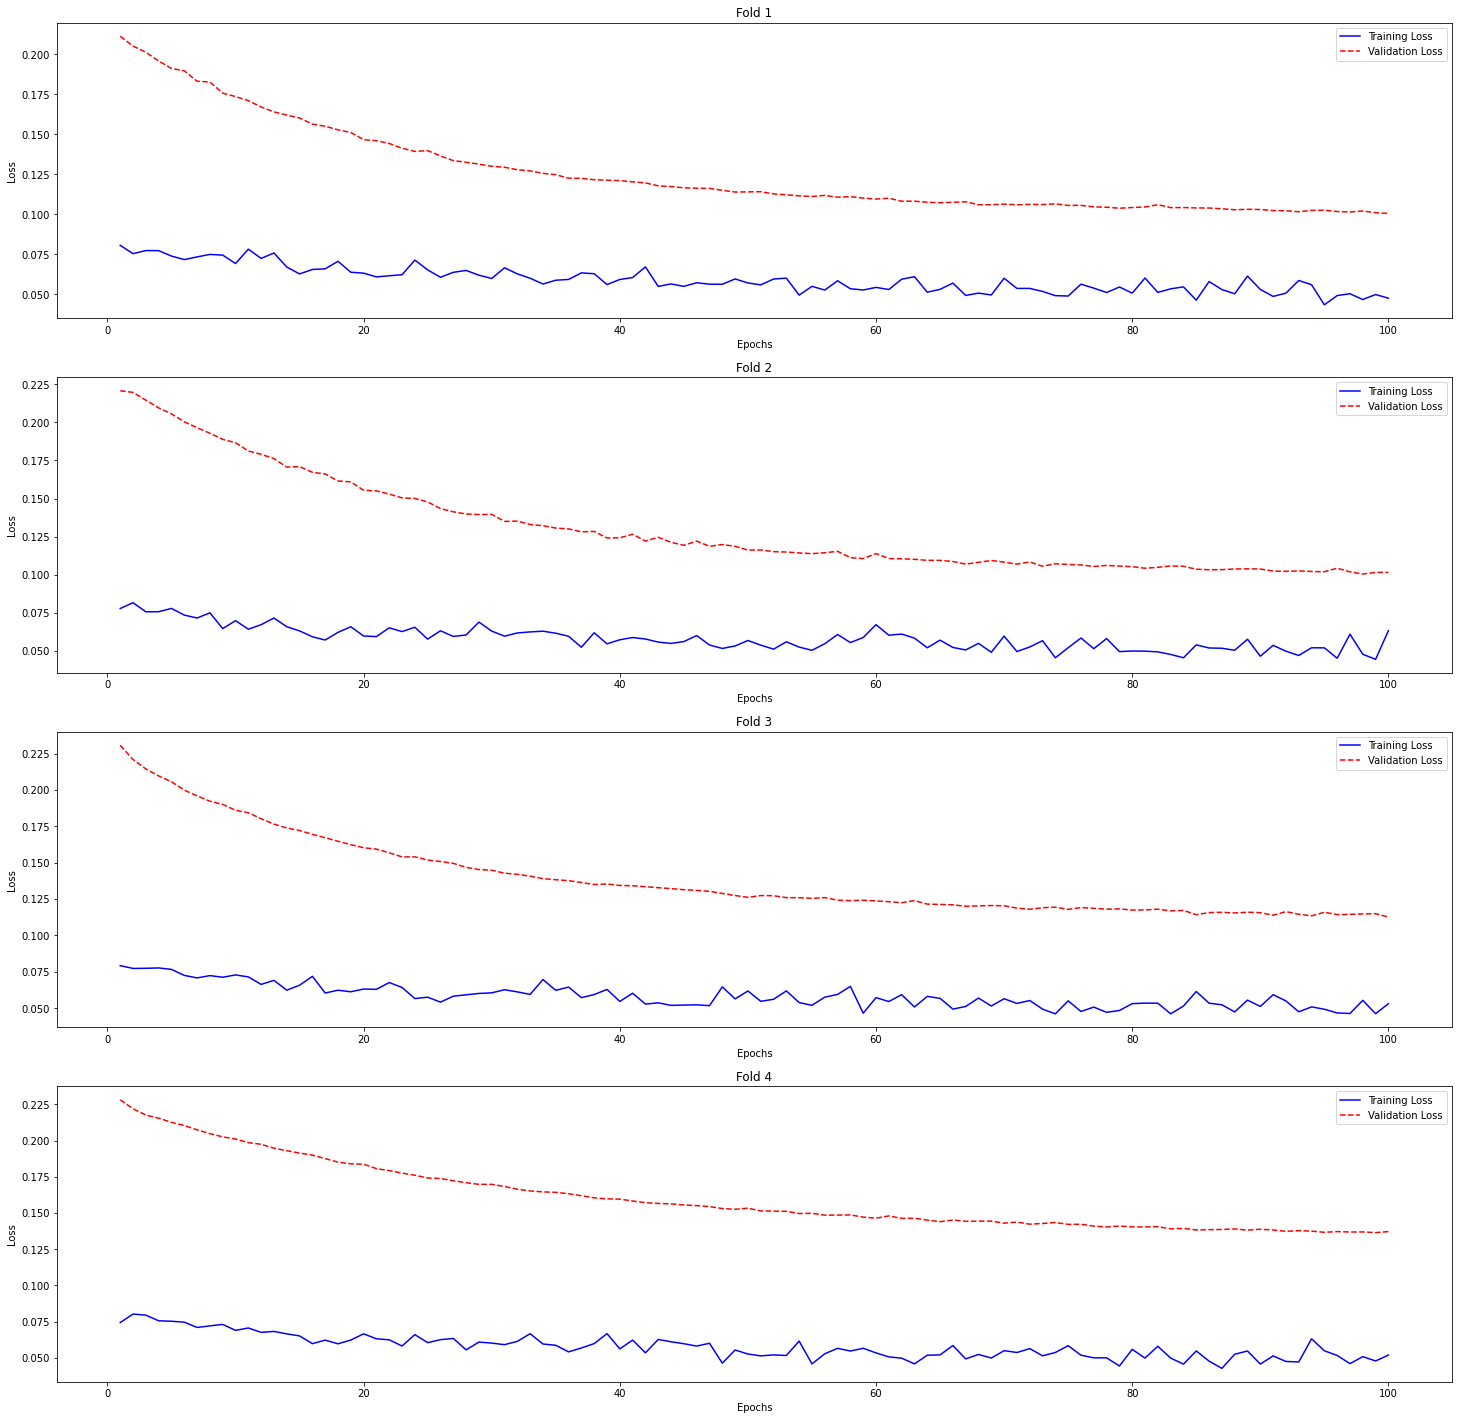

In [11]:
LP_1, Names_1, Network_1 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_1)

y_pred = eval_fn(Network_1, Names_1, ts_data)

breaker()
print("ANN_1 Accuracy : {:.4f} %".format(accuracy_score(y_test.astype(int), y_pred) * 100))
accs.append(accuracy_score(y_test, y_pred) * 100)
breaker()

LPT = []
LPV = []

for i in range(len(LP_1)):
  LPT.append(LP_1[i]["train"])
  LPV.append(LP_1[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(25, 25))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

# Configuration 2


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Processing Fold 2 ...
Processing Fold 3 ...
Processing Fold 4 ...

------------------------------

Time Taken to Train 4 folds for 100 epochs : 89.31362 seconds

------------------------------


------------------------------

ANN_2 Accuracy : 23.7776 %

------------------------------



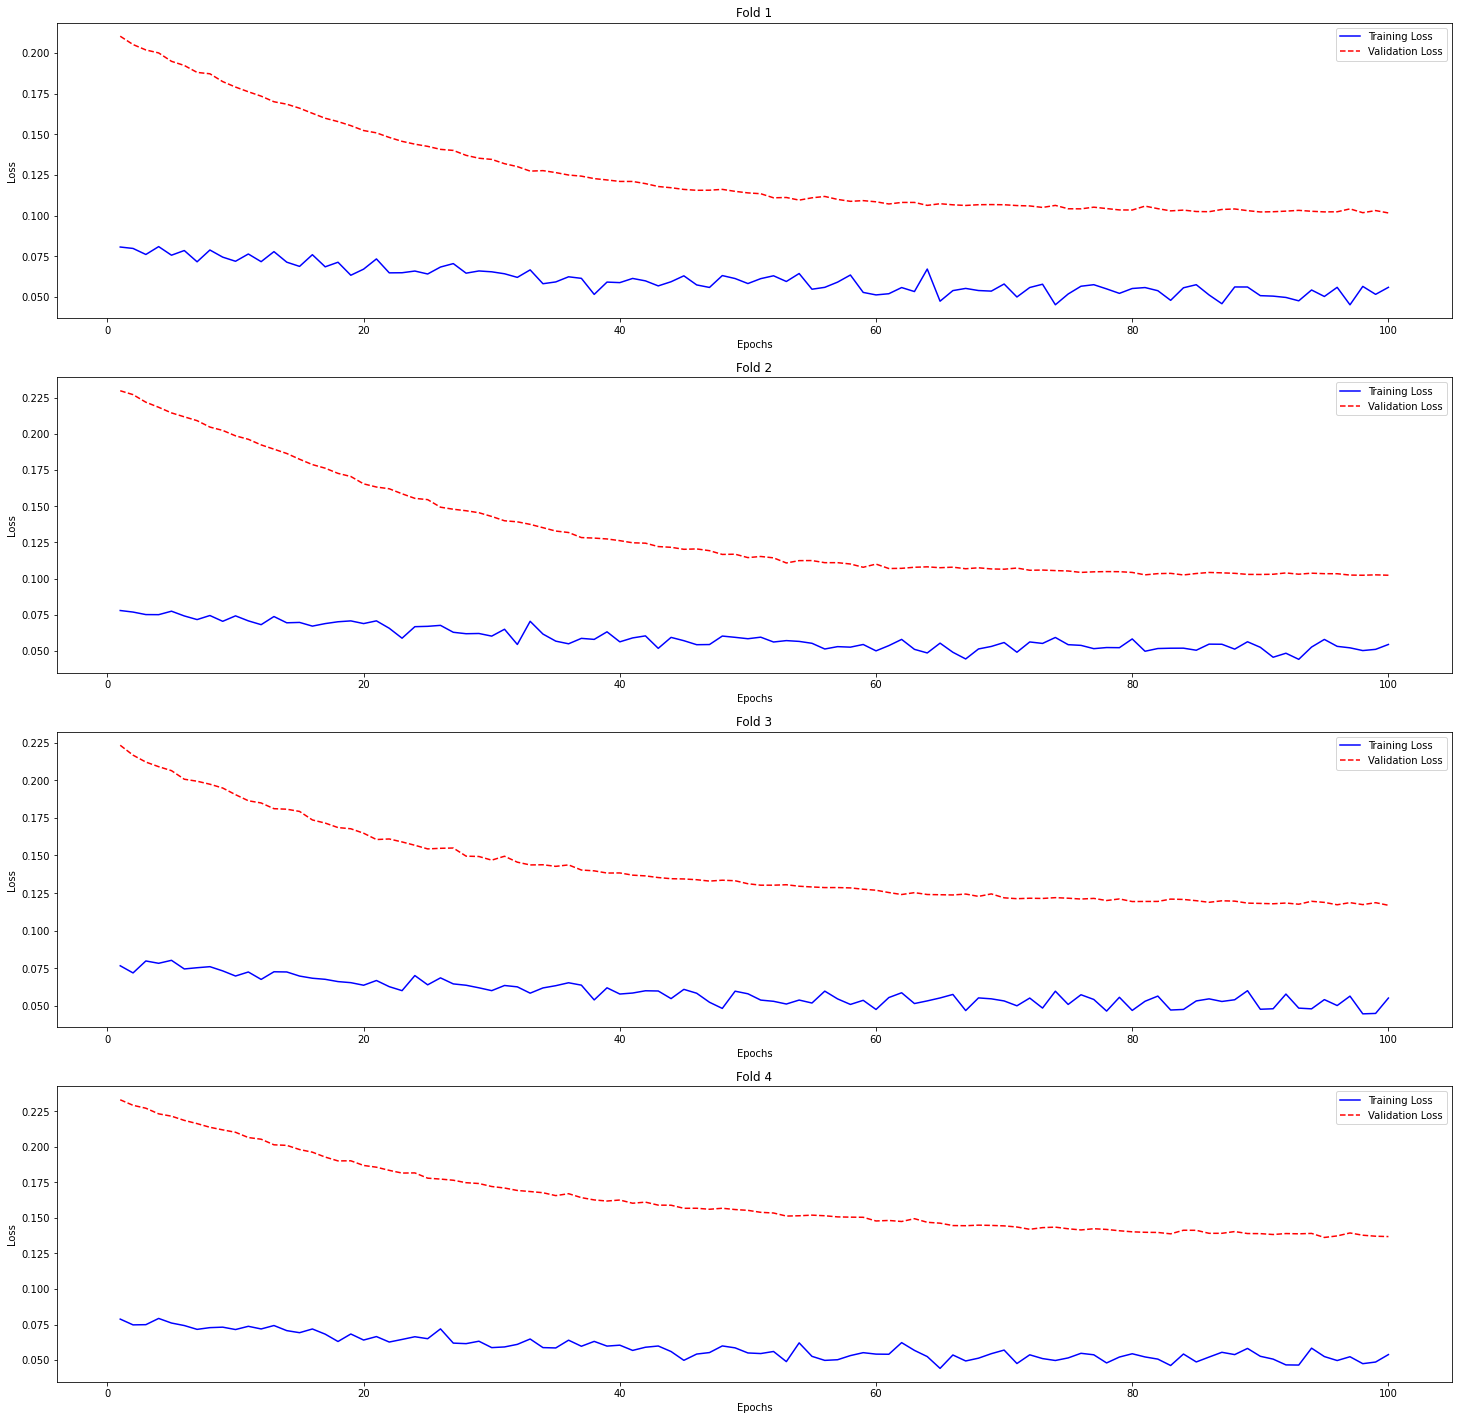

In [12]:
LP_2, Names_2, Network_2 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_2)

y_pred = eval_fn(Network_2, Names_2, ts_data)

breaker()
print("ANN_2 Accuracy : {:.4f} %".format(accuracy_score(y_test.astype(int), y_pred) * 100))
accs.append(accuracy_score(y_test, y_pred) * 100)
breaker()

LPT = []
LPV = []

for i in range(len(LP_2)):
  LPT.append(LP_2[i]["train"])
  LPV.append(LP_2[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(25, 25))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

# Plots

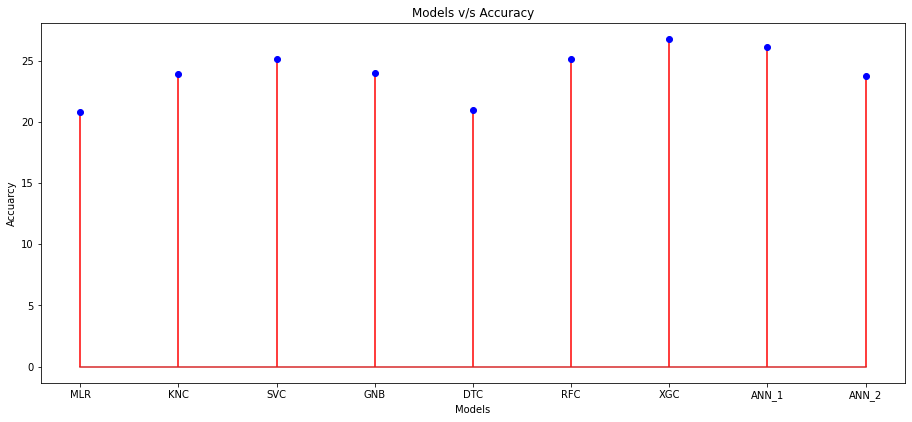

In [13]:
labels = ["MLR", "KNC", "SVC", "GNB", "DTC", "RFC", "XGC", "ANN_1", "ANN_2"]

x_Axis = [i for i in range(len(accs))]

fig = plt.figure(figsize=(12, 5))
ax = fig.add_axes([1, 1, 1, 1])
ax.stem(x_Axis, accs, markerfmt="bo", linefmt="r-", use_line_collection=True)
ax.set_xlabel("Models")
ax.set_ylabel("Accuarcy")
ax.set_title("Models v/s Accuracy")
ax.set_xticks(x_Axis)
ax.set_xticklabels(labels)
plt.show()